In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Note:
#used one single fully connected layer instead of 3 layers 
#and used batchnorm after each conv layer that did not exist originally
#input img size:32x32 thus 32/2**5=1 then we have 512*1*1 neurons in fully connected layer
class VGG(nn.Module):
    def __init__(self,in_chnls,no_classes,arch_name):
        super(VGG,self).__init__()
        self.arch_dict={'VGG16':[(2,64),(2,128),(3,256),(3,512),(3,512)],
           'VGG11':[(1,64),(1,128),(2,256),(2,512),(2,512)],
           'VGG13':[(2,64),(2,128),(2,256),(2,512),(2,512)]}
        self.in_chnls=in_chnls
        self.arch_name=arch_name
        self.blocks=self.build_vgg_blocks()
        self.fc=nn.Linear(512,no_classes)
              
    def build_vgg_blocks(self):
        layers=[]
        layers_list=self.arch_dict[self.arch_name]
        in_chnls=self.in_chnls
        
        for no_layers,out_chnls in layers_list:
            for _ in range(no_layers):
                layers+=[nn.Conv2d(in_channels=in_chnls,out_channels=out_chnls,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(out_chnls),
                nn.ReLU()]
                in_chnls=out_chnls
            layers+=[nn.MaxPool2d(kernel_size=2,stride=2)]
        return nn.Sequential(*layers)
    
    def forward(self,x):
        x=self.blocks(x)
        x=x.reshape(x.shape[0],-1)
        x=self.fc(x)
        return x
          

In [3]:
model = VGG(3,10,'VGG16')
print(model)

VGG(
  (blocks): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [4]:
#hyperparameters

no_classes=10
no_epochs=30
batch_size=100
learning_rate=0.01


In [5]:
#load data
train_trans = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

data_path='dataset/'
train_dataset=datasets.CIFAR10(root=data_path,train=True,download=True,transform=train_trans)
test_dataset=datasets.CIFAR10(root=data_path,train=False,download=True,transform=test_trans)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting dataset/cifar-10-python.tar.gz to dataset/
Files already downloaded and verified


In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
def train_val_dataset(dataset, val_split=0.8):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets


print(len(train_dataset))
datasets = train_val_dataset(train_dataset)
print('training dataset',len(datasets['train']))
vdatasets = train_val_dataset(datasets['val'],val_split=0.15)
print('validation dataset',len(vdatasets['val']))


test_datasets = train_val_dataset(test_dataset,0.4)

print(len(test_datasets['val']))

50000
training dataset 10000
validation dataset 6000
4000


In [8]:
train_loader=DataLoader(datasets['train'],batch_size,shuffle=True)
val_loader=DataLoader(vdatasets['val'],batch_size,shuffle=True)
test_loader=DataLoader(test_datasets['val'],batch_size,shuffle=True)



In [9]:
#Loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=learning_rate,momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)


In [10]:
#Train the network
from tqdm import tqdm
avg_loss=0
correct=0
total=0
avg_losses=[]
accuaracies=[]
val_accuaracies=[]
for epoch in range(no_epochs):
    model.train()
    losses = []
    acc=[]
    loss_epoch=0
    no_correct=0
    no_samples=0
    val_no_correct=0
    val_no_samples=0
    val_acc=[]
    for data,target in tqdm(train_loader):
        pred=model(data)
        loss=criterion(pred,target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss)
        
        _,ypred=pred.max(1)
        no_correct+=(ypred==target).sum()
        no_samples+=pred.size(0)
        loss_epoch += loss.item()
        
    accu=100.*no_correct/no_samples
    avg_loss = sum(losses) / len(test_loader)
    accuaracies.append(accu)
    avg_losses.append(avg_loss.item())
    
    model.eval()
    for val_data,val_target in tqdm(val_loader):
       val_pred=model(val_data)
      
      
    
      
      #print(data.shape)
      _,val_ypred=val_pred.max(1)
      val_no_correct+=(val_ypred==val_target).sum()
      val_no_samples+=val_pred.size(0)
    val_accu=100.*val_no_correct/val_no_samples
    
    val_accuaracies.append(val_accu)  
    print(f'\nepoch: {epoch}, train loss:{avg_loss.item()},training accuracy: {accu},validation accuracy: {val_accu}')

    scheduler.step()

         

    
    


100%|██████████| 60/60 [01:17<00:00,  1.28s/it]



epoch: 0, train loss:5.095779895782471,training accuracy: 27.5,validation accuracy: 29.600000381469727


100%|██████████| 60/60 [01:16<00:00,  1.28s/it]



epoch: 1, train loss:4.045653343200684,training accuracy: 39.68000030517578,validation accuracy: 40.733333587646484


100%|██████████| 60/60 [01:16<00:00,  1.28s/it]



epoch: 2, train loss:3.602965831756592,training accuracy: 47.029998779296875,validation accuracy: 49.983333587646484


100%|██████████| 60/60 [01:17<00:00,  1.29s/it]



epoch: 3, train loss:3.2486796379089355,training accuracy: 52.08000183105469,validation accuracy: 53.70000076293945


100%|██████████| 60/60 [01:16<00:00,  1.28s/it]



epoch: 4, train loss:2.9785687923431396,training accuracy: 57.09000015258789,validation accuracy: 56.36666488647461


100%|██████████| 60/60 [01:16<00:00,  1.28s/it]



epoch: 5, train loss:2.7672882080078125,training accuracy: 60.70000076293945,validation accuracy: 60.016666412353516


100%|██████████| 60/60 [01:17<00:00,  1.29s/it]



epoch: 6, train loss:2.5397417545318604,training accuracy: 64.02999877929688,validation accuracy: 61.83333206176758


100%|██████████| 60/60 [01:16<00:00,  1.28s/it]



epoch: 7, train loss:2.3135228157043457,training accuracy: 67.0,validation accuracy: 65.23332977294922


100%|██████████| 60/60 [01:16<00:00,  1.28s/it]



epoch: 8, train loss:2.178722858428955,training accuracy: 69.45999908447266,validation accuracy: 60.29999923706055


100%|██████████| 60/60 [01:17<00:00,  1.28s/it]



epoch: 9, train loss:2.0439465045928955,training accuracy: 71.41999816894531,validation accuracy: 66.25


100%|██████████| 60/60 [01:17<00:00,  1.29s/it]



epoch: 10, train loss:1.920680046081543,training accuracy: 72.97000122070312,validation accuracy: 67.5999984741211


100%|██████████| 60/60 [01:16<00:00,  1.28s/it]



epoch: 11, train loss:1.7690563201904297,training accuracy: 75.1500015258789,validation accuracy: 66.06666564941406


100%|██████████| 60/60 [01:21<00:00,  1.35s/it]



epoch: 12, train loss:1.7213157415390015,training accuracy: 76.08000183105469,validation accuracy: 68.73332977294922


100%|██████████| 60/60 [01:18<00:00,  1.31s/it]



epoch: 13, train loss:1.5682469606399536,training accuracy: 78.1500015258789,validation accuracy: 71.05000305175781


100%|██████████| 60/60 [01:18<00:00,  1.30s/it]



epoch: 14, train loss:1.4707367420196533,training accuracy: 79.5999984741211,validation accuracy: 69.75


100%|██████████| 60/60 [01:18<00:00,  1.31s/it]



epoch: 15, train loss:1.1949236392974854,training accuracy: 83.56999969482422,validation accuracy: 75.93333435058594


100%|██████████| 60/60 [01:17<00:00,  1.30s/it]



epoch: 16, train loss:1.0570284128189087,training accuracy: 85.3499984741211,validation accuracy: 78.21666717529297


100%|██████████| 60/60 [01:18<00:00,  1.30s/it]



epoch: 17, train loss:1.0035057067871094,training accuracy: 85.91999816894531,validation accuracy: 76.25


100%|██████████| 60/60 [01:17<00:00,  1.29s/it]



epoch: 18, train loss:0.9296748042106628,training accuracy: 87.2300033569336,validation accuracy: 75.36666870117188


100%|██████████| 60/60 [01:17<00:00,  1.29s/it]



epoch: 19, train loss:0.8869476318359375,training accuracy: 87.62999725341797,validation accuracy: 76.58333587646484


100%|██████████| 60/60 [01:17<00:00,  1.29s/it]



epoch: 20, train loss:0.8290791511535645,training accuracy: 88.33999633789062,validation accuracy: 76.25


100%|██████████| 60/60 [01:17<00:00,  1.29s/it]



epoch: 21, train loss:0.8324381709098816,training accuracy: 88.61000061035156,validation accuracy: 76.93333435058594


100%|██████████| 60/60 [01:17<00:00,  1.29s/it]



epoch: 22, train loss:0.7267277240753174,training accuracy: 89.9800033569336,validation accuracy: 77.0


100%|██████████| 60/60 [01:16<00:00,  1.28s/it]



epoch: 23, train loss:0.7578499913215637,training accuracy: 89.45999908447266,validation accuracy: 77.56666564941406


100%|██████████| 60/60 [01:17<00:00,  1.30s/it]



epoch: 24, train loss:0.7177420854568481,training accuracy: 90.4000015258789,validation accuracy: 75.86666870117188


100%|██████████| 60/60 [01:17<00:00,  1.30s/it]



epoch: 25, train loss:0.6691384315490723,training accuracy: 90.5199966430664,validation accuracy: 76.8499984741211


100%|██████████| 60/60 [01:17<00:00,  1.30s/it]



epoch: 26, train loss:0.6599825620651245,training accuracy: 90.66000366210938,validation accuracy: 78.43333435058594


100%|██████████| 60/60 [01:17<00:00,  1.30s/it]



epoch: 27, train loss:0.623275637626648,training accuracy: 91.13999938964844,validation accuracy: 78.19999694824219


100%|██████████| 60/60 [01:17<00:00,  1.29s/it]



epoch: 28, train loss:0.563979983329773,training accuracy: 91.6500015258789,validation accuracy: 74.81666564941406


100%|██████████| 60/60 [01:18<00:00,  1.30s/it]


epoch: 29, train loss:0.6220842003822327,training accuracy: 91.37999725341797,validation accuracy: 77.83333587646484


In [11]:
PATH = './cifar_net3.pth'
torch.save(model.state_dict(), PATH)

In [12]:
model.load_state_dict(torch.load('./cifar_net3.pth'))

<All keys matched successfully>

# New Section

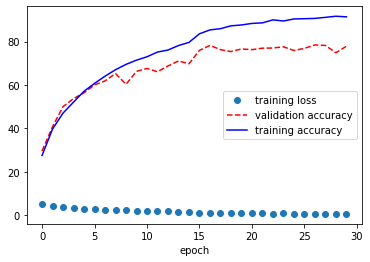

In [13]:
plt.plot(avg_losses,'o',label='training loss')
plt.plot(val_accuaracies,'r--',label='validation accuracy')
plt.plot(accuaracies,'b',label='training accuracy')
plt.xlabel('epoch')
plt.ylabel('')
plt.legend()

In [14]:
#Check the accuracy
def check_accuracy(DataLoader,model):
    no_correct=0
    no_samples=0
    model.eval()
    with torch.no_grad():
        for data, target in DataLoader:
            prediction=model(data)
            _,pred=prediction.max(1)
            no_correct+=(pred==target).sum()
            no_samples+=pred.size(0)
        print(f'accuracy={no_correct/no_samples}')
    model.train()
            

In [ ]:
check_accuracy(train_loader,model)

In [15]:
check_accuracy(test_loader,model)

accuracy=0.7887499928474426


In [18]:
def get_pred(model, dataloader):

    preds = []
    lbls = []
    model.eval()
    with torch.no_grad():

        for img, lbl in dataloader:
            lbls.append(lbl)
            pred = model(img)
            preds.append(pred)
            
    preds = torch.cat(preds, dim=0)
    lbls = torch.cat(lbls, dim=0)

    return preds, lbls

outputs, labels =  get_pred(model, test_loader)

In [20]:
pca = PCA(n_components=2)
out_pca = pca.fit_transform(outputs)

classes = test_dataset.classes
fig = plt.figure(figsize=(8, 8))

scatter = plt.scatter(out_pca[:, 0],out_pca[:, 1], c=labels,cmap='Set1')

plt.legend( labels=classes)
plt.show()

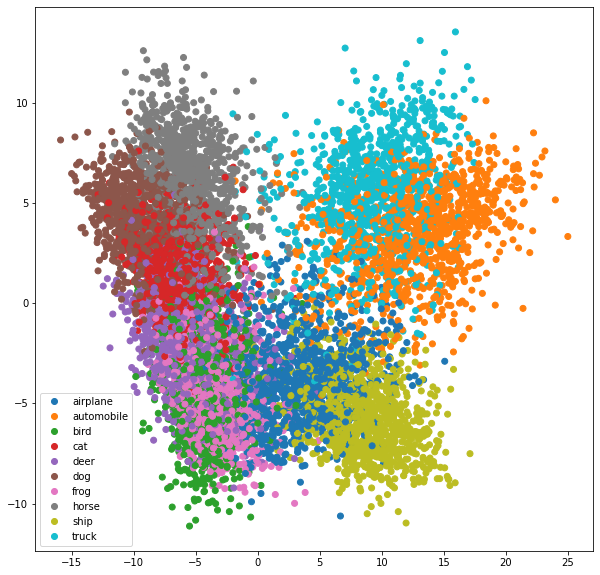

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


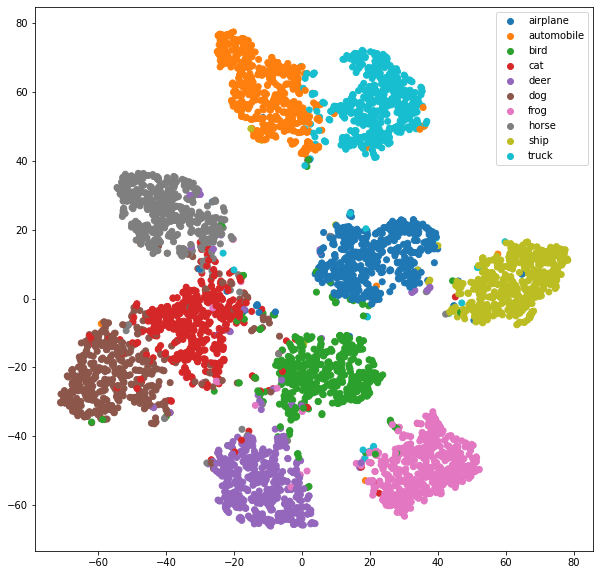

In [24]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2)
tsne_out = tsne.fit_transform(outputs)
fig = plt.figure(figsize=(8, 8))
scatter = plt.scatter(tsne_out[:, 0],tsne_out[:, 1], c=labels,cmap='Set1')
plt.legend( labels=classes)
plt.show()

In [26]:

def get_pred_softmax(model, dataloader):
    model.eval()
    preds = []
    lbls = []
    model.eval()
    with torch.no_grad():

        for img, lbl in dataloader:
            lbls.append(lbl)
            pred = model(img)
            pred = F.softmax(pred, dim=-1)
            preds.append(pred)
            
    preds = torch.cat(preds, dim=0)
    lbls = torch.cat(lbls, dim=0)

    return preds, lbls




In [27]:
preds, labels = get_pred_softmax(model, test_loader)

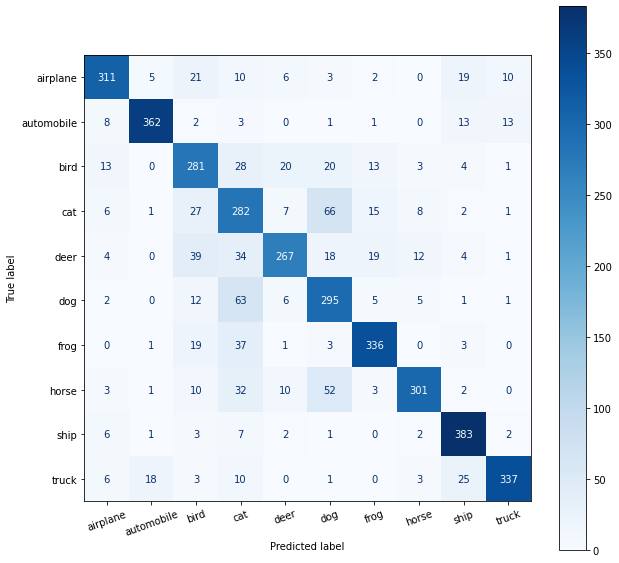

In [29]:

pred_labels = torch.argmax(preds, 1)

cm = confusion_matrix(labels, pred_labels)
cm = ConfusionMatrixDisplay(cm, display_labels=classes)
fig = plt.figure(figsize=(8, 8))
ax= plt.subplot()
cm.plot(values_format='d', cmap='Blues', ax=ax)
plt.xticks(rotation=20)
plt.show()